In [308]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from numba import njit
from sympy import Matrix


# ============================================================
# NUMBA-ACCELERATED SSA CORE
# ============================================================

@njit
def ssa_core(
    SM,
    current_pops,
    rates_list,
    current_pops_index,
    final_time,
    num_internal_species,
    stoich_cols
):
    t = 0.0 # initial time
    T = final_time # length of simulation
    burn_in = 100.0
    steady_time = 0.0

    n_species = len(current_pops) # number of species in system
    n_reactions = SM.shape[1] # number of reactions, from the SM

    # ---- Preallocate storage ----
    # max_steps = 7_000_000 # this was introduced by AI after i asked for speed-up help

    # Create empty arrays of the correct size for each data set, instead of appending to lists (much faster this way)
    # time_history = np.zeros(max_steps)
    # pop_history = np.zeros((max_steps, n_species))
    reaction_chosen_tracker = np.zeros(n_reactions)
    force_sums = np.zeros(stoich_cols)

    # Store initial state
    step_counter = 0
    #time_history[0] = t
    # pop_history[0, :] = current_pops
    


    while t < T:

        # ---- Propensity calculation ----         # move this inside instead of outsourcing to another class method
        propensity_vector = np.zeros(n_reactions)

        for a in range(n_reactions): # for each reaction

            product_of_counts = 1.0 # initialise product

            for idx in current_pops_index[a]: # for every species in this reaction, multiply their counts together. Done via indexes found earlier

                product_of_counts *= current_pops[idx]

                # print(f"ID of species used in reaction {a}: {idx}")

            propensity_vector[a] = product_of_counts * rates_list[a] # propensity calculation (kept local)

        # --------------------------------

        a0 = np.sum(propensity_vector)

        if a0 == 0.0: # prevent unphysical situation (also breaks code due to /0 error)
            break

        r1 = np.random.rand() # find random numbers
        r2 = np.random.rand()

        tau = -math.log(r1) / a0
        target_value = r2 * a0

        cumulative = 0.0
        reaction_chosen = 0

        # ---- Reaction selection ------
        # weighted towards reactions with larger propensities

        for n in range(n_reactions):

            cumulative += propensity_vector[n]

            if target_value <= cumulative:

                reaction_chosen = n

                break

        # # ---- Sampling for currents & forces ----
        # if t > 40: # hard coded burn-in time to ensure we are sampling the stationary state only (need to generalise this)

        #     reaction_chosen_tracker[reaction_chosen] += 1

        #     l = 0
        #     pair_index = 0

        #     while l < stoich_cols:

        #         if propensity_vector[l] > 0.0 and propensity_vector[l+1] > 0.0: # preventing /0 error, returns NaN otherwise

        #             force_sums[pair_index] += tau * math.log(
        #                 propensity_vector[l] / propensity_vector[l+1]
        #             )

        #         l += 2
        #         pair_index += 1

        # NEW sampling from AI:

        
        t_next = t + tau

        if t_next > burn_in:

            # amount of time actually inside steady-state window
            if t < burn_in:
                tau_effective = t_next - burn_in
            else:
                tau_effective = tau

            steady_time += tau_effective
            reaction_chosen_tracker[reaction_chosen] += 1

            l = 0
            pair_index = 0

            while l < 2*stoich_cols: # x2 to include forward and backward reaction

                if propensity_vector[l] > 0.0 and propensity_vector[l+1] > 0.0:

                    force_sums[pair_index] += tau_effective * math.log(
                        propensity_vector[l] / propensity_vector[l+1]
                    )

                l += 2
                pair_index += 1

        # ---- Updates ----
        t += tau

        for m in range(num_internal_species):
            current_pops[m] += SM[m, reaction_chosen] # update populations using the stoichometric coefficients of the chosen reaction

        # ---- Store trajectory ---- # AI coded, for tracking time for plotting later (replaces an append method to a list of times)
        # step_counter += 1
        # if step_counter >= max_steps:
        #     break

        # time_history[step_counter] = t
        # pop_history[step_counter, :] = current_pops # stores the newest updated set of populations

    # Trim arrays # AI coded, is to remove useless data from initial array size estimate
    # time_history = time_history[:step_counter + 1]
    # pop_history = pop_history[:step_counter + 1, :]

    return (
        
        current_pops,
        reaction_chosen_tracker,
        force_sums,
        steady_time
    )

    # time_history,
        #pop_history both removed


# ============================================================
# CLASS
# ============================================================

class RunSSA:

    def __init__(self, module_for_simulating, initial_counts, rates, simulation_length):

        self.stoich_matrix = module_for_simulating.stoich_matrix
        self.species_names = module_for_simulating.species_names
        self.current_pops = initial_counts
        self.rates_list = rates
        self.final_time = simulation_length
        self.num_internal_species = module_for_simulating.num_internal_species

        # Run these immediately to give useful variables for later
        self.SM_with_reverse_stoichiometry = self.create_SM_with_reverse_stoichiometry() # SM with reverse reactions included
        
        # Finds the indexes (corresponding identically) in the species list for each species involved in each reaction
        self.current_pops_index = self.determine_consumed_species_in_each_reaction() 


    def create_SM_with_reverse_stoichiometry(self):

        SM = []

        for p in range(self.stoich_matrix.cols):
            SM.append(self.stoich_matrix[:, p])
            SM.append(-self.stoich_matrix[:, p])

        self.SM_with_reverse_stoichiometry = Matrix.hstack(*SM)
        return self.SM_with_reverse_stoichiometry


    def determine_consumed_species_in_each_reaction(self):

        self.current_pops_index = []

        for l in range(self.SM_with_reverse_stoichiometry.cols):

            reaction = self.SM_with_reverse_stoichiometry[:, l]
            current_reaction_indexes = []

            for p in range(len(reaction)):
                if reaction[p] < 0:
                    current_reaction_indexes.append(p)

            self.current_pops_index.append(current_reaction_indexes)

        return self.current_pops_index


    def run_SSA_and_plot_counts(self):

        # ------------------------------------------
        # Assign self variables to local variables so that we can run a NJIT speed-up on the SSA loop later

        SM_np = np.array(self.SM_with_reverse_stoichiometry).astype(np.float64)

        current_pops_np = np.array(self.current_pops, dtype=np.float64)

        rates_np = np.array(self.rates_list, dtype=np.float64)
    
        current_pops_index_np = [
            np.array(lst, dtype=np.int64) for lst in self.current_pops_index
        ]
        # ------------------------------------------

        # ------------------------------------------
        # Run the SSA loop, assigning varaible produced by the function

        loop_time_start = time.time()

        #time_history,
        #    pop_history, removed from below
        
        (
            
            final_pops,
            reaction_chosen_tracker,
            force_sums,
            steady_time
        ) = ssa_core(
            SM_np,
            current_pops_np,
            rates_np,
            current_pops_index_np,
            self.final_time,
            self.num_internal_species,
            self.stoich_matrix.cols
        )

        # print(f"steady_time = {steady_time:.4f}, final t = {time_history[-1]:.4f}")

        loop_time_end = time.time()

        # convert useful properties back into class variables:

        self.current_pops = final_pops.tolist()
        # self.time_history = time_history
        # self.pop_history = pop_history

        # ------------------------------------------

        # ============================================================
        # PRINT FINAL COUNTS
        # ============================================================

        # for m in range(self.num_internal_species):
        #     print(r'Final {}: {}'.format(
        #         self.species_names[m],
        #         pop_history[-1, m]
        #     ))

        # print(r'No. times each reaction fires: {}'.format(reaction_chosen_tracker))

        # ============================================================
        # AVERAGE REACTION CURRENTS
        # ============================================================

        self.average_reaction_currents = []

        g = 0

        while g < len(reaction_chosen_tracker):

            current = (
                reaction_chosen_tracker[g] - reaction_chosen_tracker[g+1]
            ) / steady_time#(self.final_time - 40)

            self.average_reaction_currents.append(current)
            g += 2

        # print("steady_time =", steady_time)
        # print("N_f - N_b =", reaction_chosen_tracker[0] - reaction_chosen_tracker[1])

        # print(r'Averaged currents of each reaction: {}'.format(
        #     self.average_reaction_currents))

        # ============================================================
        # AVERAGE FORCES
        # ============================================================

        self.averaged_forces = (force_sums / steady_time).tolist() # /steady time instead of self.final_time - 40

        self.steady_time = steady_time

        # print(r'Averaged forces along each reaction: {}'.format(
        #     self.averaged_forces))

        # ============================================================
        # AVERAGE RESISTANCES
        # ============================================================

        self.average_resistances = []

        for i in range(self.stoich_matrix.cols):

            if (self.averaged_forces[i] != 0 and
                self.average_reaction_currents[i] != 0):

                self.average_resistances.append(
                    self.averaged_forces[i] /
                    self.average_reaction_currents[i]
                )
            else:
                self.average_resistances.append(np.nan)

        # print(r'Averaged resistances: {}'.format(
        #     self.average_resistances))

        # print(r"Total Loop time: {}".format(
        #     loop_time_end - loop_time_start))

        

        # ============================================================
        # PLOT COUNTS VS TIME
        # ============================================================

        # plt.figure(figsize=(8,5))

        # for m in range(self.num_internal_species):
        #     plt.step(
        #         self.time_history,
        #         self.pop_history[:, m],
        #         where="post",
        #         label=self.species_names[m]
        #     )

        # plt.xlabel("Time")
        # plt.ylabel("Molecule count")
        # plt.title("Gillespie SSA Simulation")
        # plt.legend()
        # plt.grid(True)
        # plt.tight_layout()
        # plt.show()

My SSA ^

## AI version to plot counts

In [ ]:
# import numpy as np
# import math
# import time
# import matplotlib.pyplot as plt
# from numba import njit
# from sympy import Matrix


# # ============================================================
# # NUMBA-ACCELERATED SSA CORE
# # ============================================================

# @njit
# def ssa_core(
#     SM,
#     current_pops,
#     rates_list,
#     current_pops_index,
#     final_time,
#     num_internal_species,
#     stoich_cols,
#     max_steps                 # new parameter
# ):
#     t = 0.0
#     T = final_time
#     burn_in = 40.0
#     steady_time = 0.0

#     n_species = len(current_pops)
#     n_reactions = SM.shape[1]

#     # ---- Preallocate storage ----
#     time_history = np.zeros(max_steps)
#     pop_history = np.zeros((max_steps, n_species))
#     reaction_chosen_tracker = np.zeros(n_reactions)
#     force_sums = np.zeros(stoich_cols)

#     # Store initial state
#     step_counter = 0
#     time_history[0] = t
#     pop_history[0, :] = current_pops

#     while t < T:
#         # Propensity calculation (unchanged)
#         propensity_vector = np.zeros(n_reactions)
#         for a in range(n_reactions):
#             product_of_counts = 1.0
#             for idx in current_pops_index[a]:
#                 product_of_counts *= current_pops[idx]
#             propensity_vector[a] = product_of_counts * rates_list[a]

#         a0 = np.sum(propensity_vector)
#         if a0 == 0.0:
#             break

#         r1 = np.random.rand()
#         r2 = np.random.rand()
#         tau = -math.log(r1) / a0
#         target_value = r2 * a0

#         cumulative = 0.0
#         reaction_chosen = 0
#         for n in range(n_reactions):
#             cumulative += propensity_vector[n]
#             if target_value <= cumulative:
#                 reaction_chosen = n
#                 break

#         # Sampling for currents & forces (unchanged)
#         t_next = t + tau
#         if t_next > burn_in:
#             if t < burn_in:
#                 tau_effective = t_next - burn_in
#             else:
#                 tau_effective = tau
#             steady_time += tau_effective
#             reaction_chosen_tracker[reaction_chosen] += 1

#             l = 0
#             pair_index = 0
#             while l < 2 * stoich_cols:
#                 if propensity_vector[l] > 0.0 and propensity_vector[l+1] > 0.0:
#                     force_sums[pair_index] += tau_effective * math.log(
#                         propensity_vector[l] / propensity_vector[l+1]
#                     )
#                 l += 2
#                 pair_index += 1

#         # Update time and populations
#         t += tau
#         for m in range(num_internal_species):
#             current_pops[m] += SM[m, reaction_chosen]

#         # Store trajectory (new)
#         step_counter += 1
#         if step_counter >= max_steps:
#             # If we run out of space, break or could resize, but we'll break for safety
#             break
#         time_history[step_counter] = t
#         pop_history[step_counter, :] = current_pops

#     # Trim arrays to actual length
#     time_history = time_history[:step_counter + 1]
#     pop_history = pop_history[:step_counter + 1, :]

#     return (
#         current_pops,
#         reaction_chosen_tracker,
#         force_sums,
#         steady_time,
#         time_history,      # new
#         pop_history        # new
#     )


# # ============================================================
# # CLASS
# # ============================================================

# class RunSSA:

#     def __init__(self, module_for_simulating, initial_counts, rates, simulation_length):
#         # ... (unchanged) ...
#         self.stoich_matrix = module_for_simulating.stoich_matrix
#         self.species_names = module_for_simulating.species_names
#         self.current_pops = initial_counts
#         self.rates_list = rates
#         self.final_time = simulation_length
#         self.num_internal_species = module_for_simulating.num_internal_species

#         self.SM_with_reverse_stoichiometry = self.create_SM_with_reverse_stoichiometry()
#         self.current_pops_index = self.determine_consumed_species_in_each_reaction()

#     def create_SM_with_reverse_stoichiometry(self):
#         # ... (unchanged) ...
#         SM = []
#         for p in range(self.stoich_matrix.cols):
#             SM.append(self.stoich_matrix[:, p])
#             SM.append(-self.stoich_matrix[:, p])
#         self.SM_with_reverse_stoichiometry = Matrix.hstack(*SM)
#         return self.SM_with_reverse_stoichiometry

#     def determine_consumed_species_in_each_reaction(self):
#         # ... (unchanged) ...
#         self.current_pops_index = []
#         for l in range(self.SM_with_reverse_stoichiometry.cols):
#             reaction = self.SM_with_reverse_stoichiometry[:, l]
#             current_reaction_indexes = []
#             for p in range(len(reaction)):
#                 if reaction[p] < 0:
#                     current_reaction_indexes.append(p)
#             self.current_pops_index.append(current_reaction_indexes)
#         return self.current_pops_index

#     def run_SSA_and_plot_counts(self):
#         # Prepare numpy arrays for numba
#         SM_np = np.array(self.SM_with_reverse_stoichiometry).astype(np.float64)
#         current_pops_np = np.array(self.current_pops, dtype=np.float64)
#         rates_np = np.array(self.rates_list, dtype=np.float64)
#         current_pops_index_np = [
#             np.array(lst, dtype=np.int64) for lst in self.current_pops_index
#         ]

#         # Set a safe maximum number of steps (adjust as needed)
#         max_steps = 10_000_000

#         loop_time_start = time.time()

#         # Run the SSA core (now returns time_history and pop_history)
#         (
#             final_pops,
#             reaction_chosen_tracker,
#             force_sums,
#             steady_time,
#             time_history,
#             pop_history
#         ) = ssa_core(
#             SM_np,
#             current_pops_np,
#             rates_np,
#             current_pops_index_np,
#             self.final_time,
#             self.num_internal_species,
#             self.stoich_matrix.cols,
#             max_steps
#         )

#         loop_time_end = time.time()

#         # Store results in instance variables
#         self.current_pops = final_pops.tolist()
#         self.time_history = time_history
#         self.pop_history = pop_history
#         self.steady_time = steady_time

#         # Compute average currents, forces, resistances (unchanged) ...
#         self.average_reaction_currents = []
#         g = 0
#         while g < len(reaction_chosen_tracker):
#             current = (
#                 reaction_chosen_tracker[g] - reaction_chosen_tracker[g+1]
#             ) / steady_time
#             self.average_reaction_currents.append(current)
#             g += 2

#         self.averaged_forces = (force_sums / steady_time).tolist()

#         self.average_resistances = []
#         for i in range(self.stoich_matrix.cols):
#             if (self.averaged_forces[i] != 0 and
#                 self.average_reaction_currents[i] != 0):
#                 self.average_resistances.append(
#                     self.averaged_forces[i] /
#                     self.average_reaction_currents[i]
#                 )
#             else:
#                 self.average_resistances.append(np.nan)

#         # ============================================================
#         # PLOT COUNTS VS TIME
#         # ============================================================
#         plt.figure(figsize=(8,5))
#         for m in range(self.num_internal_species):
#             plt.step(
#                 self.time_history,
#                 self.pop_history[:, m],
#                 where="post",
#                 label=self.species_names[m]
#             )
#         plt.xlabel("Time")
#         plt.ylabel("Molecule count")
#         plt.title("Gillespie SSA Simulation")
#         plt.legend()
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()

#         # Optionally print loop time
#         print(f"Total loop time: {loop_time_end - loop_time_start:.4f} s")

## ModuleProperties and CombiningModules code

In [17]:
# all imports

import hypernetx as hnx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
#init_printing(use_unicode=True)
warnings.simplefilter('ignore')
import re
from sympy import *
import sympy
init_printing()

class ModuleProperties:

    def __init__(self, stoich_matrix, num_internal_species, species_names):
        self.stoich_matrix = sympy.Matrix(stoich_matrix)
        self.num_internal_species = num_internal_species
        self.num_external_species = self.stoich_matrix.shape[0] - num_internal_species
        self.num_species = self.stoich_matrix.shape[0]
        self.num_reactions = self.stoich_matrix.shape[1]
        self.species_labels = {i: item for i, item in enumerate(species_names)}
        self.species_names = species_names
        self.internal_stoich_matrix = self.stoich_matrix[0:self.num_internal_species, :]
        self.external_stoich_matrix = self.stoich_matrix[self.num_internal_species: len(self.stoich_matrix), :]


        # LABELLING FOR SPECIES, FORCES, EDGE CURRENTS, CHEMICAL POTENTIALS

        #self.species_labels = []

        self.chemical_potentials = []
     

        for n in range(self.num_species):
            
            #species_symbol = species_names[n]
            species_symbol = symbols(species_names[n])
            #self.species_labels.append(species_symbol)

            chem_pot = symbols(f"\mu_{species_symbol}")
            self.chemical_potentials.append(chem_pot)
            

        self.chemical_potentials_vector = Matrix(self.chemical_potentials).T  # make a vector out of the labelled chemical potentials
        
        # LABELS FOR ALL RESISTANCES AND REACTIONS

        
        resistances = [] # define list to hold reaction labels
        edge_currents_j = [] # to hold the js
        forces = [] # to hold reaction level forces

        for n in range(self.num_reactions): # loop over each reaction
            nth_resistance = symbols(f"r{n+1}") # assign name of nth resistance
            resistances.append(nth_resistance) # add to list of resistance

            nth_edge_currents_j = symbols(f"j{n+1}") # assign name of nth edge current
            edge_currents_j.append(nth_edge_currents_j) # add to list of currents

            reaction_vector = -1* self.stoich_matrix[:,n] # take the column of SM that corresponds to nth reaction
            
            forces.append(self.chemical_potentials_vector*reaction_vector) # use reaction vector *-1  in SM to create forces in terms of chem potentials
        
        
        self.force_vector = Matrix(forces) # create a vector of reaction level forces
        self.edge_currents_vector = Matrix(edge_currents_j) # make a vector out of the js


        # reaction resistance in terms of r = f/j

        reaction_level_res = [] # to hold reaction level resistances

        for n in range(self.num_reactions): # loop over each reaction
            symbolic_resistance = self.force_vector[n] / self.edge_currents_vector[n]

            reaction_level_res.append(symbolic_resistance)

        self.reaction_level_resistances = reaction_level_res # output reaction level resistances in terms of r = f/j

        self.kinetic_form_resistance_matrix = Matrix.diag(reaction_level_res) # output reaction level res. matrix in terms of r = f/j

    #==========================================================================================================================================
    # REACTION LEVEL CYCLES

    def calculate_reaction_cycle_matrix(self):

        """ This method calculates the reaction level cycles matrix for the internal species of the module using the 
        kernel of the internal stoichiometric matrix.
        
        Returns:
            cycle_matrix (Sympy Matrix): Reaction level cycles matrix for internal species
        """
        
        reaction_cycles = (self.internal_stoich_matrix).nullspace() # finds the kernel for the SM internal

        # Check if there are any cycles:

        if not reaction_cycles:

            print("No internal cycles. Kernel is empty.")

        # build cycle matrix from kernel vectors if kernel is NOT empty

        else:

            cycle_matrix = reaction_cycles[0] # add first vector to cycle matrix so we can add rest later

            for cycle in reaction_cycles[1:]: # starting at second vector in kernel

                cycle_matrix = cycle_matrix.row_join(cycle) # connect vectors from kernel column-wise, row_join puts elemetns of adjacent vectors together


            self.cycle_matrix = cycle_matrix # assign cycle matrix to self for use in other methods
            
            return cycle_matrix # return the cycle matrix
        
    #==========================================================================================================================================
    # COUPLING MATRICES 
 
    def calculate_coupling_matrix(self):

        """ This method calculates the coupling matrix between internal and external species using reaction cycle matrix 
        and SM of external species.

        Returns:
            phi (Sympy Matrix): Coupling matrix between internal and external species
        """

        phi = self.external_stoich_matrix * self.calculate_reaction_cycle_matrix()

        self.phi = phi
        return phi
    
    #==========================================================================================================================================
    # CONSERVATION LAW MATRICES

    def calculate_conservation_laws(self):

        """ This method calculates the conservation law matrices for the full stoichiometric matrix and the chemostat species only.
        
        Returns:
            cons_laws.T (Sympy Matrix): Conservation law matrix for the full stoichiometric matrix  
            chemostat_laws.T (Sympy Matrix): Conservation law matrix for the chemostat species only
        """

        cokernel_SM = (self.stoich_matrix.T).nullspace() # finds the cokernel of the full SM

        if not cokernel_SM:

            print("No conservation laws. Cokernel of Stoichiometric Matrix empty.")

        else:

            cons_laws = cokernel_SM[0] # adds first element of cokernel

            for vec in cokernel_SM[1:]: # add vectors from next row onwards

                cons_laws = cons_laws.row_join(vec)


        #
        # Broken external laws for chemostat , deriving from the coupling matrix
        #

        coupling_matrix = self.calculate_coupling_matrix() # define the coupling matrix using the function defined previously

        cokernel_coupling_matrix = coupling_matrix.T.nullspace() # find the cokernel of the coupling matrix

        if not cokernel_coupling_matrix:

            print("No chemostat conservation laws. Cokernel of Coupling Matrix is empty.")

        # if cokernel is NOT empty

        else:

            chemostat_laws = cokernel_coupling_matrix[0] # add first vector to chemostat conservation law matrix so we can add rest later

            for law in cokernel_coupling_matrix[1:]: # starting at second vector in kernel

                chemostat_laws = chemostat_laws.row_join(law) # connect vectors from kernel column-wise, row_join puts elemetns of adjacent vectors together



        self.cons_laws = cons_laws.T # assign to self for use in other methods
        self.chemostat_cons_laws = chemostat_laws.T # assign to self for use in other methods

        return cons_laws.T, chemostat_laws.T # return transpose to match equations in paper { L^(1) and l^(1) respectively}
    
    #==========================================================================================================================================
    # SELECTION MATRIX

    def calculate_selection_matrix(self):

        """ This method calculates the selection matrix for the chemostat conservation laws.
        
        Returns:
            selection_matrix (Sympy Matrix): Selection matrix for the chemostat conservation laws
        """

        chemostat_laws = self.calculate_conservation_laws()[1] # get chemostat conservation laws from previous method

        null_basis_chemostat_laws = (chemostat_laws).nullspace() # find nullspace of chemostat conservation laws

        if null_basis_chemostat_laws:

            selection_matrix = sympy.Matrix.hstack(*null_basis_chemostat_laws) # build selection matrix from nullspace vectors

        else:

            selection_matrix = sympy.Matrix([]) # empty matrix if no nullspace

        self.selection_matrix = selection_matrix # assign to self for use in other methods

        return selection_matrix

    #==========================================================================================================================================
    # PHYSICAL CURRENTS

    def calculate_physical_currents(self):

        currents_constraints = sympy.solve (self.internal_stoich_matrix * self.edge_currents_vector, self.edge_currents_vector)

        physical_currents = (-1* self.external_stoich_matrix * self.edge_currents_vector).subs(currents_constraints)

        self.physical_currents = physical_currents # assign to self for use in other methods

        return physical_currents

    #==========================================================================================================================================
    # REACTION LEVEL RESISTANCE MATRIX
    
    def calculate_reaction_resistance_matrix(self):

        """ Calculates the reaction level resistance matrix for the module, including an auto-labelling of reactions in the SM 
        according to the number of columns in the SM for use in Sympy operations.

        Returns:
            reaction_resistance_matrix (Sympy Matrix): Reaction level resistance matrix for the module"""
                    
        resistances = [] # define list to hold reaction labels
    
        for n in range(self.num_reactions): # loop over each reaction

            nth_reaction = symbols(f"r{n+1}") # assign name of nth reaction

            resistances.append(nth_reaction) # add to list of reactions


    
        reaction_resistance_matrix = Matrix.diag(resistances) # create diagonal reaction level resistance matrix from list of reactions

        self.reaction_resistance_matrix = reaction_resistance_matrix # assign to self for use in other methods

        return reaction_resistance_matrix

    #==========================================================================================================================================
    # CYCLE RESISTANCE MATRIX

    def calculate_cycle_resistance_matrix(self):

        """ Uses the reaction level resistance matrix and reaction cycles matrix to calculate the cycle resistance matrix for the module.
        
        Returns:
            cycle_resistance_matrix (Sympy Matrix): Cycle resistance matrix for the module"""

        cycle_resistance_matrix = self.calculate_reaction_cycle_matrix().T * self.calculate_reaction_resistance_matrix() \
        * self.calculate_reaction_cycle_matrix()

        self.cycle_resistance_matrix = cycle_resistance_matrix # assign to self for use in other methods

        return cycle_resistance_matrix    
    
    #==========================================================================================================================================
    # PHYSICAL CONDUCATANCE MATRICES

    def calculate_physical_conductance_matrix(self):
        """ This method calculates the physical conductance matrix for the module using the coupling matrix and cycle resistance matrix.

        Returns:
            physical_conductance_matrix (Sympy Matrix): Physical conductance matrix for the module
        """

        physical_conductance_matrix = self.calculate_coupling_matrix() * self.calculate_cycle_resistance_matrix().inv() \
              * self.calculate_coupling_matrix().T        

        self.physical_conductance_matrix = physical_conductance_matrix # assign to self for use in other methods

        return physical_conductance_matrix
    
    #==========================================================================================================================================
    # FUNDAMENTAL CONDUCTANCE MATRIX

    def calculate_fundamental_conductance_matrix(self):
        """ This method calculates the fundamental conductance matrix for the module using the selection matrix and physical conductance matrix.

        Returns:
            fundamental_conductance_matrix (Sympy Matrix): Fundamental conductance matrix for the module
        """

        fundamental_conductance_matrix = self.calculate_selection_matrix().pinv() * self.calculate_physical_conductance_matrix() * self.calculate_selection_matrix().T.pinv()

        self.fundamental_conductance_matrix = fundamental_conductance_matrix # assign to self for use in other methods

        return fundamental_conductance_matrix
    
    #==========================================================================================================================================
    # FUNDAMENTAL RESISTANCE MATRIX

    def calculate_fundamental_resistance_matrix(self):
        """ This method calculates the fundamental resistance matrix for the module using the selection matrix and physical conductance matrix.

        Returns:
            fundamental_resistance_matrix (Sympy Matrix): Fundamental resistance matrix for the module
        """

        fundamental_resistance_matrix = self.calculate_fundamental_conductance_matrix().inv()

        self.fundamental_resistance_matrix = fundamental_resistance_matrix # assign to self for use in other methods

        return fundamental_resistance_matrix

    
class CombiningModules:

    def __init__(self, left_mod, right_mod):
                
        #=====================================================================================================================================
        # IDENTIFY MATCHING EXTERNAL SPECIES

        left_ext_indices  = list(range(left_mod.num_internal_species, left_mod.num_species)) # external species indices for left module
        right_ext_indices = list(range(right_mod.num_internal_species, right_mod.num_species)) # external species indices for right module

        left_ext_names  = {i: left_mod.species_labels[i] for i in left_ext_indices} # external species names for left module
        right_ext_names = {j: right_mod.species_labels[j] for j in right_ext_indices} # external species names for right module

        matching_pairs = []
        for i_ext, name_i in left_ext_names.items(): # loop over left external species
            for j_ext, name_j in right_ext_names.items(): # loop over right external species
                if name_i == name_j: # check for matching names
                    matching_pairs.append((i_ext, j_ext)) # store matching index pairs

        if matching_pairs: # if there are matching pairs
            keys_1, keys_2 = zip(*matching_pairs) # unzip into separate lists
            keys_1, keys_2 = list(keys_1), list(keys_2) # convert to lists
        else:
            keys_1, keys_2 = [], [] # no matches found

        # Convert global species indices → external row indices
        left_match_rows  = [i - left_mod.num_internal_species  for i in keys_1] # left module matching external row indices
        right_match_rows = [j - right_mod.num_internal_species for j in keys_2] # right module matching external row indices

        #===================================================================================================================================
        # COMPUTE LEFT AND RIGHT PHYSICAL CURRENTS AND SOLVE MATCHING CONSTRAINTS

        left_curr  = left_mod.calculate_physical_currents() # physical currents for left module
        right_curr = right_mod.calculate_physical_currents() # physical currents for right module

        left_right_current  = sympy.Matrix([left_curr[r]  for r in left_match_rows]) # left module matching external currents
        right_left_current  = sympy.Matrix([right_curr[r] for r in right_match_rows]) # right module matching external currents

        left_left_current = sympy.Matrix([left_curr[r] for r in range(left_mod.num_external_species)
            if r not in left_match_rows]) # creates a matrix of left unmatched external currents

        right_right_current = sympy.Matrix([right_curr[r] for r in range(right_mod.num_external_species)
            if r not in right_match_rows]) # creates a matrix of right unmatched external currents

        constraint_eqs = [left_right_current[k] + right_left_current[k]
            for k in range(len(left_right_current)) ] # build list of constraint equations for matching currents

        symbols_to_solve = left_right_current.free_symbols # get symbols to solve for from left matching currents
        solutions = sympy.solve(constraint_eqs, symbols_to_solve) # solve constraints for matching currents

        left_curr  = left_curr.subs(solutions) # substitute solutions into left physical currents
        right_curr = right_curr.subs(solutions) # substitute solutions into right physical currents

        left_left_current = sympy.Matrix([left_curr[r] for r in range(left_mod.num_external_species)
            if r not in left_match_rows]) # creates a matrix of left unmatched external currents after substitution

        right_right_current = sympy.Matrix([right_curr[r] for r in range(right_mod.num_external_species)
            if r not in right_match_rows]) # creates a matrix of right unmatched external currents after substitution

        combined_currents = sympy.Matrix.vstack(left_left_current, right_right_current) # creates a vector of physical currents for combined module
        self.physical_currents = combined_currents # assign to self for use in other methods

        #======================================================================================================================================
        # BUILDING THE COMBINED STOICHIOMETRIC MATRIX

        matching_stoich_left = sympy.Matrix([left_mod.external_stoich_matrix.row(r) for r in left_match_rows]) # matching external stoich rows from left module

        matching_stoich_right = sympy.Matrix([right_mod.external_stoich_matrix.row(r) for r in right_match_rows]) # matching external stoich rows from right module

        external_left_unmatched = sympy.Matrix([left_mod.external_stoich_matrix.row(r)
            for r in range(left_mod.external_stoich_matrix.rows)
            if r not in left_match_rows]) # unmatched external stoich rows from left module

        external_right_unmatched = sympy.Matrix([right_mod.external_stoich_matrix.row(r)
            for r in range(right_mod.external_stoich_matrix.rows)
            if r not in right_match_rows]) # unmatched external stoich rows from right module

        stoich_matrix = BlockMatrix([
            [left_mod.internal_stoich_matrix,
            zeros(left_mod.internal_stoich_matrix.rows, right_mod.internal_stoich_matrix.cols)],

            [matching_stoich_left,
            matching_stoich_right],

            [zeros(right_mod.internal_stoich_matrix.rows, left_mod.internal_stoich_matrix.cols),
            right_mod.internal_stoich_matrix],

            [external_left_unmatched,
            zeros(external_left_unmatched.rows, right_mod.internal_stoich_matrix.cols)],

            [zeros(external_right_unmatched.rows, left_mod.internal_stoich_matrix.cols),
            external_right_unmatched]]) # build combined stoichiometric matrix using sympy BlockMatrix

        self.stoich_matrix = sympy.Matrix(stoich_matrix) # convert BlockMatrix to regular Matrix and assign to self

        # ===================================================================================================================================
        # UPDATING ATTRIBUTES OF THE COMBINED MODULE TO WORK WITH OTHER METHODS

        self.num_internal_species = (left_mod.num_internal_species + right_mod.num_internal_species + len(keys_1)) # total internal species count for combined module

        self.num_external_species = self.stoich_matrix.rows - self.num_internal_species # total external species count for combined module
        self.num_species = self.stoich_matrix.rows # total species count for combined module
        self.num_reactions = left_mod.num_reactions + right_mod.num_reactions # total reactions count for combined module

        self.internal_stoich_matrix = self.stoich_matrix[:self.num_internal_species, :]
        self.external_stoich_matrix = self.stoich_matrix[self.num_internal_species:, :]

        # ===================================================================================================================================
        # CREATING A COMBINED DICTIONARY OF SPECIES LABELS

        left_internal_idx  = list(range(left_mod.num_internal_species)) # internal species indices for left module
        right_internal_idx = list(range(right_mod.num_internal_species)) # internal species indices for right module

        left_external_idx  = left_ext_indices # external species indices for left module
        right_external_idx = right_ext_indices # external species indices for right module

        left_ext_name_to_idx  = {left_mod.species_labels[i]: i for i in left_external_idx} # mapping of left external species names to indices
        right_ext_name_to_idx = {right_mod.species_labels[i]: i for i in right_external_idx} # mapping of right external species names to indices

        matching_names = set(left_ext_name_to_idx) & set(right_ext_name_to_idx) # find matching external species names

        left_matching_idx  = [left_ext_name_to_idx[name]  for name in matching_names] # indices of matching external species in left module
        right_matching_idx = [right_ext_name_to_idx[name] for name in matching_names] # indices of matching external species in right module

        left_unmatched_idx  = [i for i in left_external_idx  if i not in left_matching_idx] # indices of unmatched external species in left module
        right_unmatched_idx = [i for i in right_external_idx if i not in right_matching_idx] # indices of unmatched external species in right module

        combined_labels = {} # initialize empty dictionary for combined species labels
        counter = 0 # counter for combined species indices

        for i in left_internal_idx: # add left internal species labels
            combined_labels[counter] = left_mod.species_labels[i]
            counter += 1

        for i in left_matching_idx: # add matching species labels from left module
            combined_labels[counter] = left_mod.species_labels[i]
            counter += 1

        for i in right_internal_idx: # add right internal species labels
            combined_labels[counter] = right_mod.species_labels[i]
            counter += 1

        for i in left_unmatched_idx: # add unmatched species labels from left module
            combined_labels[counter] = left_mod.species_labels[i]
            counter += 1

        for i in right_unmatched_idx: # add unmatched species labels from right module
            combined_labels[counter] = right_mod.species_labels[i]
            counter += 1

        self.species_labels = combined_labels # assign to self for use in other methods
        self.species_names = list(combined_labels.values()) # list of combined species names

        #=========================================================================================================================================
        # Left right splitting the conservation law matrices

        left_mod_chemostat_cons_laws = left_mod.calculate_conservation_laws()[1]
        right_mod_chemostat_cons_laws = right_mod.calculate_conservation_laws()[1]

        left_mod_left_cons_laws = left_mod_chemostat_cons_laws[:, :len(left_left_current)]
        left_mod_right_cons_laws = left_mod_chemostat_cons_laws[:, len(left_left_current):]
        right_mod_left_cons_laws = right_mod_chemostat_cons_laws[:, :len(right_left_current)]
        right_mod_right_cons_laws = right_mod_chemostat_cons_laws[:, len(right_left_current):]

        #=========================================================================================================================================
        # Constructing matrices L_i, L_e and v using these to determine the chemostat conservation laws of the combined module and the selection matrix

        L_i = sympy.Matrix.vstack(-left_mod_right_cons_laws, right_mod_left_cons_laws)

        L_e = sympy.BlockMatrix([
        [left_mod_left_cons_laws, sympy.ZeroMatrix(left_mod_left_cons_laws.shape[0], right_mod_right_cons_laws.shape[1])],
        [sympy.ZeroMatrix(right_mod_right_cons_laws.shape[0], left_mod_left_cons_laws.shape[1]), right_mod_right_cons_laws]])
        
        L_e = sympy.Matrix(L_e)  

        null_basis_L_i = (L_i.T).nullspace()
        if null_basis_L_i:
            v = sympy.Matrix.hstack(*null_basis_L_i).T
        else:
            v = sympy.Matrix([])

        combined_conservation_laws_chemostat = v * L_e
        self.conservation_laws_chemostat = combined_conservation_laws_chemostat

        null_basis_cons_laws = (combined_conservation_laws_chemostat).nullspace()
        if null_basis_cons_laws:
            combined_selection_matrix = sympy.Matrix.hstack(*null_basis_cons_laws)
        else:
            combined_selection_matrix = sympy.Matrix([])

        self.selection_matrix = combined_selection_matrix

        #=========================================================================================================================================
        # Calculating pi and PI matricies 

        pi = sympy.Matrix(L_i.pinv() * L_e)
        pi_rows, pi_cols = pi.shape

        identity_part_1 = sympy.eye(len(left_left_current), pi_cols)
        pi_1_3 = identity_part_1.col_join(pi)

        identity_part_2 = sympy.eye(len(right_right_current), pi_cols-pi_rows)
        zeros_part_2 = sympy.zeros(len(right_right_current), pi_rows)
        bottom_part_2 = zeros_part_2.row_join(identity_part_2)
        pi_2_3 = (-pi).col_join(bottom_part_2)

        PI_1_3 = sympy.Matrix(left_mod.selection_matrix.pinv() * pi_1_3 * combined_selection_matrix)
        PI_2_3 = sympy.Matrix(right_mod.selection_matrix.pinv() * pi_2_3 * combined_selection_matrix)

        #=========================================================================================================================================
        # Relabelling conductance matrix of right module so that the indicies do not overlap with those of the left module

        SUB_TO_DIGIT = {'₀':'0','₁':'1','₂':'2','₃':'3','₄':'4','₅':'5','₆':'6','₇':'7','₈':'8','₉':'9'}
        DIGIT_TO_SUB = {v:k for k,v in SUB_TO_DIGIT.items()}

        def parse_symbol_name(name):
            if '_' in name:
                prefix, idx = name.split('_', 1)
                if idx.isdigit():
                    return prefix, idx, 'underscore'
            i = len(name)-1
            while i >= 0 and name[i].isdigit():
                i -= 1
            if i < len(name)-1:
                return name[:i+1], name[i+1:], 'ascii'
            i = len(name)-1
            while i >= 0 and name[i] in SUB_TO_DIGIT:
                i -= 1
            if i < len(name)-1:
                prefix = name[:i+1]
                idx = ''.join(SUB_TO_DIGIT[ch] for ch in name[i+1:])
                return prefix, idx, 'unicode'
            return None, None, None

        def build_name(prefix, new_index, style):
            if style == 'underscore':
                return f"{prefix}_{new_index}"
            if style == 'unicode':
                return f"{prefix}{''.join(DIGIT_TO_SUB[d] for d in str(new_index))}"
            return f"{prefix}{new_index}"

        def shift_expr_variables(expr, shift):
            symbols = expr.atoms(sympy.Symbol)
            if not symbols:
                return expr
            subs = {}
            for s in symbols:
                prefix, idx_str, style = parse_symbol_name(s.name)
                if prefix is None:
                    continue
                new_idx = int(idx_str) + int(shift)
                new_name = build_name(prefix, new_idx, style)
                subs[s] = sympy.Symbol(new_name, **s.assumptions0)
            return expr.xreplace(subs)

        def shift_matrix_variables(matrix, shift):
            return matrix.applyfunc(lambda e: shift_expr_variables(e, shift))
        
        left_mod_fundamental_resistance_matrix = left_mod.fundamental_resistance_matrix
        right_mod_fundamental_resistance_matrix = shift_matrix_variables(right_mod.fundamental_resistance_matrix, left_mod.num_reactions)

        #=========================================================================================================================================
        # Calculating the conductance matrix of the combined module

        combined_fundamental_resistance_matrix = PI_1_3.T * left_mod_fundamental_resistance_matrix * PI_1_3 + PI_2_3.T * right_mod_fundamental_resistance_matrix * PI_2_3

        #=========================================================================================================================================
        # Storing attributes to self that are need for an iterative process of combining modules

        self.fundamental_resistance_matrix = combined_fundamental_resistance_matrix
        self.fundamental_conductance_matrix = combined_fundamental_resistance_matrix.inv()
        self.selection_matrix = combined_selection_matrix
        self.conservation_laws_chemostat = combined_conservation_laws_chemostat

    def calculate_physical_currents(self):
        
        return self.physical_currents
    
    def calculate_conservation_laws(self):
        
        return 0, self.conservation_laws_chemostat


        
        

## Module 1 

In [ ]:
# MODULE 1


SM = Matrix( [[-1,1,0], [1,-1,-1], [0,0,1], [-1,0,-1], [0,1,0]])

species_names = ["Ea", "EaS","EaS2","S","Na"]

module_for_simulating = ModuleProperties(SM, 3, species_names)

# RunSSA input requiremetns 

# initial_S_counts = list(np.linspace(50, 1000, 200))

initial_counts = [200,200 , 200, 100, 100]

rates = 0.1* np.array([0.005, 0.8, 0.6, 0.002, 0.012, 0.5])

simulation_length = 400.0
# 
t1 = time.time()

SIM = RunSSA(module_for_simulating, initial_counts, rates, simulation_length)
SIM.run_SSA_and_plot_counts()

t2 = time.time()

print(t2 - t1)



0.7541229724884033


## Module 2

In [246]:
# MODULE 2

stoich_matrix_2 = Matrix([[-1, 0, 1, 0, 0], # first row of internal
                           [1, -1, 0, -1, 0], 
                           [0, 1, -1, 0, 1], 
                           [0, 0, 0, 1, -1],
                             [0, 0, 0, -1, 0], # first row external 
                             [0, 0, 0, 0, 1],
                             [-1, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0]])


species_names2 = ["Eb", "EbF", "EbW", "Eb*", "Na", "Nb", "F", "W"]

module_for_simulating2 = ModuleProperties(stoich_matrix_2, 4, species_names2)

# RunSSA input requiremetns 

# initial_S_counts = list(np.linspace(50, 1000, 100))

initial_counts2 = [350,350, 350, 350, 50, 50, 50, 50]

rates2 = 0.1 * np.array([0.01, 1.0, 1.0, 0.5, 1.5, 0.01, 0.01, 1.0, 1.2, 0.01])

simulation_length = 400.0
# 

time1 = time.time()
SIM2 = RunSSA(module_for_simulating2, initial_counts2, rates2, simulation_length)
SIM2.run_SSA_and_plot_counts()
time2 = time.time()

print(time2 - time1)

0.025470972061157227


In [309]:
# Script to repeat SSA for same intial coniditions to see variablility in results:
# - could have differences due to seeding of random numbers? Mentioned in Gillespie (i think)

#iteration = 0

# currents = []
# forces = []
# resistances = []

total_iterations = 400

# initial_counts_S_runs = [350,350 , 350, 150, 150]

# rates_S_runs = 0.1* np.array([0.005, 0.8, 0.6, 0.002, 0.012, 0.5])

simulation_length_S_runs = 750.0

initial_S_counts = list(np.linspace(50, 500, 50, dtype=int))


I_axis_means = []
F_axis_means = []

current_variances = []
force_variances = []

For_loop_run = 0

t_s = time.time()



for new_count in initial_S_counts:

    
    iteration = 0

    currents = np.zeros((total_iterations, 5))
    forces = np.zeros((total_iterations, 5))
    

    # SIM1 = RunSSA(module_for_simulating, initial_counts_S_runs, rates_S_runs, simulation_length_S_runs)
    SIM2 = RunSSA(module_for_simulating2, initial_counts2, rates2, simulation_length_S_runs)

    # numba initialise

    SIM2.run_SSA_and_plot_counts()


    for iteration in range(total_iterations):
        

        # SIM1.current_pops = [350,350 , 350, new_count, 150]

        # SIM1.run_SSA_and_plot_counts() # run the simulation

        SIM2.current_pops = [350,350, 350, 350, new_count, 50, 50, 50] # vary species Na

        SIM2.run_SSA_and_plot_counts()

        currents[iteration] = SIM2.average_reaction_currents
        forces[iteration] = SIM2.averaged_forces

        iteration += 1


    #Calculate averages, and add to list for IV curve plotting
        
    I_axis_means.append(np.mean(currents, axis = 0)) # axis = 0 makes sure that there is column-wise averaging (no mixing of reaction data)
    F_axis_means.append(np.mean(forces, axis = 0))

    current_variances.append(np.var(currents, axis = 0, ddof = 1))
    force_variances.append(np.var(forces, axis = 0, ddof = 1))

    print(f"S loops complete: {For_loop_run + 1}")
    For_loop_run += 1

tf = time.time()
print(tf - t_s)


        




S loops complete: 1
S loops complete: 2
S loops complete: 3
S loops complete: 4
S loops complete: 5
S loops complete: 6
S loops complete: 7
S loops complete: 8
S loops complete: 9
S loops complete: 10
S loops complete: 11
S loops complete: 12
S loops complete: 13
S loops complete: 14
S loops complete: 15
S loops complete: 16
S loops complete: 17
S loops complete: 18
S loops complete: 19
S loops complete: 20
S loops complete: 21
S loops complete: 22
S loops complete: 23
S loops complete: 24
S loops complete: 25
S loops complete: 26
S loops complete: 27
S loops complete: 28
S loops complete: 29
S loops complete: 30
S loops complete: 31
S loops complete: 32
S loops complete: 33
S loops complete: 34
S loops complete: 35
S loops complete: 36
S loops complete: 37
S loops complete: 38
S loops complete: 39
S loops complete: 40
S loops complete: 41
S loops complete: 42
S loops complete: 43
S loops complete: 44
S loops complete: 45
S loops complete: 46
S loops complete: 47
S loops complete: 48
S

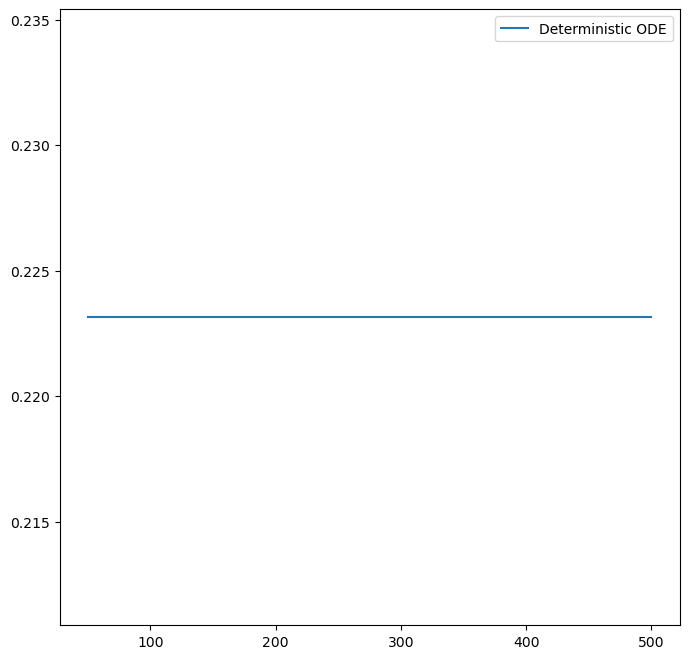

In [ ]:
# import numpy as np
# from scipy.optimize import fsolve

# # Rate constants
# k1f, k1b, k2f, k2b, k3f, k3b = 0.1* np.array([0.005, 0.8, 0.6, 0.002, 0.012, 0.5])#[0.005, 0.8, 0.6, 0.002, 0.012, 0.5]# [0.005, 0.02, 0.6, 0.002, 0.012, 0.05]

# # Total enzyme
# E_T = 200 + 200 + 200  

# # Chemostats
# Na_value = 50
# # S_value = 50


# def steady_state_solver(Na_Value):

#     def equations(vars):
#         Ea, EaS, EaS2 = vars

#         j1 = k1f * Ea * S_value - k1b * EaS
#         j2 = k2f * EaS - k2b * Ea * Na_value
#         j3 = k3f * EaS * S_value - k3b * EaS2

#         eq1 = -j1 + j2
#         eq2 = j1 - j2 - j3
#         eq3 = Ea + EaS + EaS2 - E_T

#         return [eq1, eq2, eq3]

#     # initial guess
#     guess = [E_T/3, E_T/3, E_T/3] # give a starting point for the solver

#     solution = fsolve(equations, guess)

#     return solution  # Ea_det, EaS_det, EaS2_det


# def deterministic_force(Na_value):

#     Ea_det, EaS_det, EaS2_det = steady_state_solver(Na_value)

#     force = np.log(
#         (k1f * S_value * Ea_det) /
#         (k1b * EaS_det)
#     )

#     return force

# #S_values = np.linspace(50, 500, 50, dtype=int)

# det_forces = []

# for S in initial_S_counts:
#     det_forces.append(deterministic_force(S))

# import matplotlib.pyplot as plt

# plt.plot(S_values, det_forces, label="Deterministic ODE")
# plt.legend()
# plt.show()

## Collect data for iteratoins vs analytical plot:

In [ ]:
one_it_I = [sub[1] for sub in I_axis_means]
one_it_F = [sub[1] for sub in F_axis_means]
one_it_time = tf-t_s
one_it_I_var = [sub[1] for sub in current_variances]
one_it_F_var = [sub[1] for sub in force_variances]

# FILLED

In [ ]:
ten_it_I = [sub[1] for sub in I_axis_means]
ten_it_F = [sub[1] for sub in F_axis_means]
ten_it_time = tf-t_s
ten_it_I_var = [sub[1] for sub in current_variances]
ten_it_F_var = [sub[1] for sub in force_variances]

# FILLED

In [ ]:
hun_it_I = [sub[1] for sub in I_axis_means]
hun_it_F = [sub[1] for sub in F_axis_means]
hun_it_time = tf-t_s
hun_it_I_var = [sub[1] for sub in current_variances]
hun_it_F_var = [sub[1] for sub in force_variances]

# FILLED

## Different iterations compared to analytical plot:

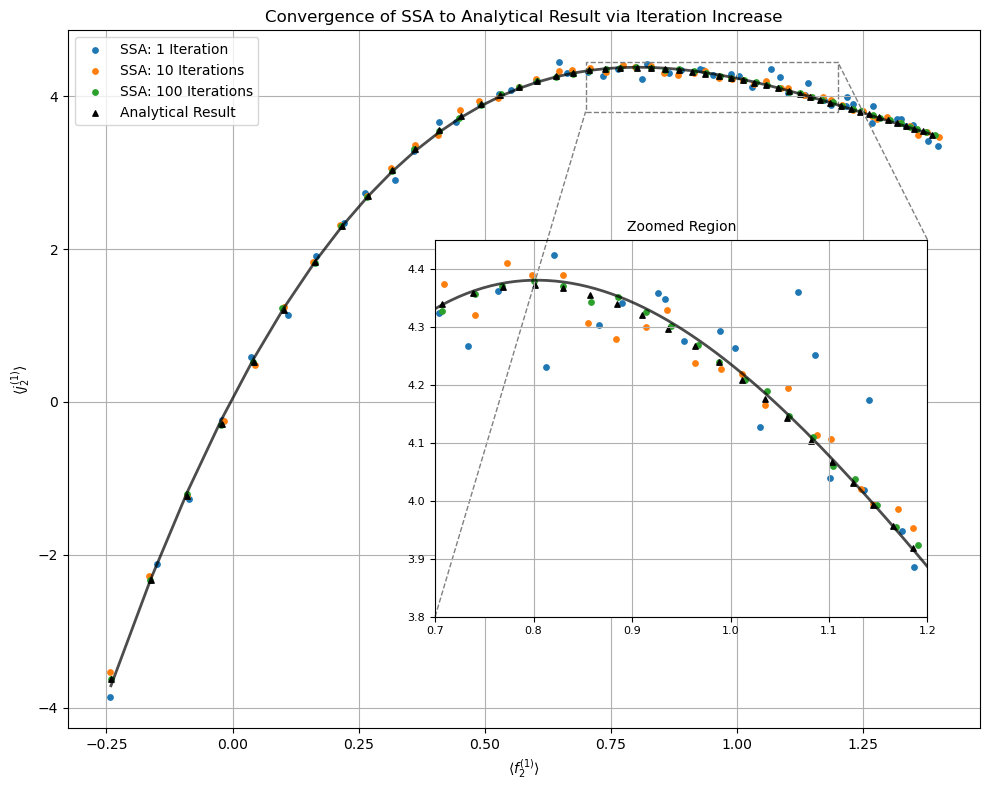

In [172]:
# plt.scatter(one_it_F, one_it_I, label = 'SSA: 1 Iteration', s =10)
# plt.scatter(ten_it_F, ten_it_I, label = 'SSA: 10 Iterations', s =10)
# plt.scatter(hun_it_F, hun_it_I, label = 'SSA: 100 Iterations', s =10)
# plt.scatter(analytical_force2, analytical_current2, label = 'Analytical Result', s =10)
# plt.legend()
# plt.title("Convergence of SSA to Analytical Result via Iteration Increase")
# plt.xlabel(r'$<f_2^{(1)}>$')
# plt.ylabel(r'$<j_2^{(1)}>$')
# plt.xlim(0.5,1.3)
# plt.ylim(3,5)
# plt.show()


from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Create the main plot
fig, ax = plt.subplots(figsize=(10, 8))

# Your original scatter plots on the main axes
ax.scatter(one_it_F, one_it_I, label='SSA: 1 Iteration', s=15)
ax.scatter(ten_it_F, ten_it_I, label='SSA: 10 Iterations', s=15)
ax.scatter(hun_it_F, hun_it_I, label='SSA: 100 Iterations', s=15)
ax.scatter(analytical_force2, analytical_current2, label='Analytical Result', s=15, color ='black', marker = '^')
ax.legend()
ax.set_title("Convergence of SSA to Analytical Result via Iteration Increase")
ax.set_xlabel(r'$\langle f_2^{(1)} \rangle$')
ax.set_ylabel(r'$\langle j_2^{(1)} \rangle$')
ax.grid(True)

# Add a fitted line for the analytical data
# Sort the data for proper line plotting
sort_idx = np.argsort(analytical_force2)
force_sorted = np.array(analytical_force2)[sort_idx]
current_sorted = np.array(analytical_current2)[sort_idx]

# Fit a polynomial (adjust degree as needed)
# For example, degree 2 for quadratic fit
coeffs = np.polyfit(force_sorted, current_sorted, 3)  # Change degree as needed
fitted_curve = np.polyval(coeffs, force_sorted)

# Plot the fitted line
ax.plot(force_sorted, fitted_curve, color = 'black',label='Analytical Fit', linewidth=2, alpha=0.7)

# Create an inset axes in the bottom right corner
# Parameters: parent_axes, width, height, loc (lower right)
axins = inset_axes(ax, width="90%", height="90%", loc='lower right', bbox_to_anchor=(0.35, 0.15, 0.6, 0.6),  # (x, y, width, height)
                   bbox_transform=ax.transAxes)  # Moved up from 0.25 to 0.35)

# Plot the zoomed-in region on the inset axes
axins.scatter(one_it_F, one_it_I, s=15)
axins.scatter(ten_it_F, ten_it_I, s=15)
axins.scatter(hun_it_F, hun_it_I, s=15)
axins.scatter(analytical_force2, analytical_current2, s=15, color = 'black', marker = '^')

force_dense = np.linspace(min(analytical_force2), max(analytical_force2), 200)
current_dense = np.polyval(coeffs, force_dense)
axins.plot(force_dense, current_dense, 'black', linewidth=2, alpha=0.7)

# Set the limits for the zoomed region - YOU NEED TO SPECIFY THESE
# Example: zoom in on x from 0.8 to 1.2 and y from 0.8 to 1.2
x1, x2 = 0.7, 1.2  # Replace with your desired x limits
y1, y2 = 3.8, 4.45  # Replace with your desired y limits
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Optional: Add a rectangle in the main plot showing the zoomed region
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="gray", linestyle="--")

# Optional: Customize the inset
axins.set_title('Zoomed Region', fontsize=10)
# You can remove tick labels if they clutter the inset
axins.tick_params(labelsize=8)

plt.tight_layout()
plt.grid(True)
plt.show()

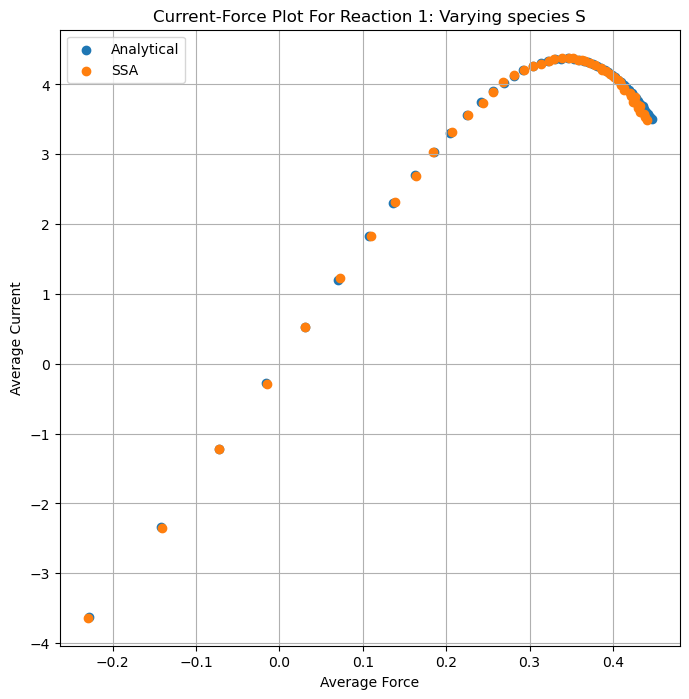

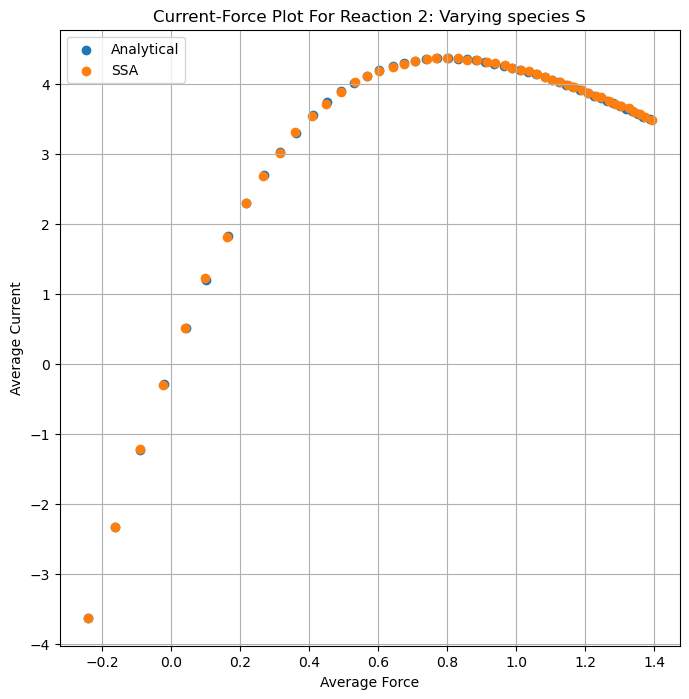

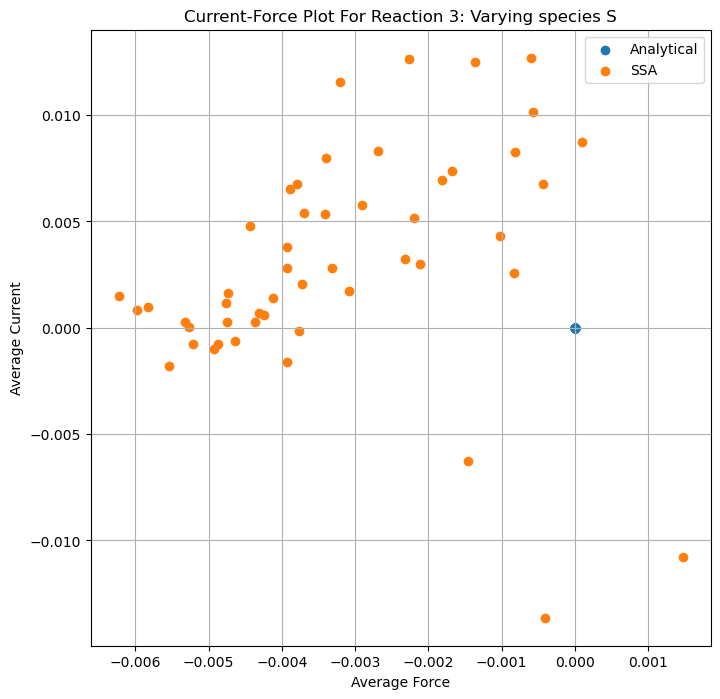

In [174]:
# Use my analytical expression for the current and force of reaction 1 in terms of varying S and rates only


rates = 0.1* np.array([0.005, 0.8, 0.6, 0.002, 0.012, 0.5])
k1f = rates[0]
k1b = rates[1]
k2f = rates[2]
k2b = rates[3]
k3f = rates[4]
k3b = rates[5]

Na = 150
# S = 150

E_T = 350*3 #initial_counts[0] + initial_counts[1] + initial_counts[2] # total internal species (shouldn't change due to conservation)

analytical_current1 = []
analytical_force1 = []

analytical_current2 = []
analytical_force2 = []

analytical_current3 = []
analytical_force3 = []



for S in initial_S_counts:

    chi = (k2f + k1b)/(k1f*S + k2b*Na)

    j1 = (k1f*k2f*S - k1b*k2b*Na)*E_T / (((k1f*S + k2b*Na)*(1+ k3f*S/k3b))+k2f+k1b)

    f1 = np.log( (k1f*S*(k1b+k2f)) / (k1b*(k1f*S + k2b*Na)) )

    j2 = (E_T *k2f - E_T*k2b*Na*chi)/(1 + chi + k3f*S/k3b )
    
    f2 = np.log( (k2f*(k1f*S + k2b*Na) / (k2b*Na*(k2f + k1b)) ))

    j3 = 0

    f3 = 0

    analytical_current1.append(j1)
    analytical_force1.append(f1)

    analytical_current2.append(j2)
    analytical_force2.append(f2)

    analytical_current3.append(j3)
    analytical_force3.append(f3)


# REACTION 1

plt.title("Current-Force Plot For Reaction 1: Varying species S")
plt.xlabel("Average Force")
plt.ylabel("Average Current")
plt.scatter(analytical_force1, analytical_current1, label = 'Analytical')
plt.scatter([sub[0] for sub in F_axis_means], [sub[0] for sub in I_axis_means], label = 'SSA')

# plt.errorbar([sub[0] for sub in F_axis_means], [sub[0] for sub in I_axis_means], yerr=np.sqrt(current_var), xerr=np.sqrt(force_var), fmt='none', ecolor='grey', alpha=0.5)
plt.grid(True)
#cbar = plt.colorbar(scatter)
# cbar.set_label('Initial S Count')
plt.legend()
plt.show()

# plt.title("Current-S counts Plot For Reaction 1")
# plt.xlabel("S count")
# plt.ylabel("Average Current")
# plt.scatter(initial_S_counts, analytical_current, label = 'Analytical')
# plt.scatter(initial_S_counts, [sub[0] for sub in I_axis_means], label = 'SSA')
# # plt.errorbar(first_reaction_x, first_reaction_y, yerr=np.sqrt(current_var), fmt='none', ecolor='grey', alpha=0.5)
# plt.grid(True)
# # cbar = plt.colorbar(scatter)
# # cbar.set_label('Initial S Count')
# plt.legend()
# plt.show()

# plt.title("Force-S counts Plot For Reaction 1")
# plt.xlabel("S count")
# plt.ylabel("Average Force")
# plt.scatter(initial_S_counts, analytical_force, label = 'Analytical')
# plt.scatter(initial_S_counts, [sub[0] for sub in F_axis_means], label = 'SSA')
# # plt.errorbar(first_reaction_x, first_reaction_y, yerr=np.sqrt(force_var), fmt='none', ecolor='grey', alpha=0.5)
# plt.grid(True)
# # cbar = plt.colorbar(scatter)
# # cbar.set_label('Initial S Count')
# plt.legend()
# plt.show()


# REACTION 2

plt.title("Current-Force Plot For Reaction 2: Varying species S")
plt.xlabel("Average Force")
plt.ylabel("Average Current")
plt.scatter(analytical_force2, analytical_current2, label = 'Analytical')
plt.scatter([sub[1] for sub in F_axis_means], [sub[1] for sub in I_axis_means], label = 'SSA')
# plt.errorbar([sub[0] for sub in F_axis_means], [sub[0] for sub in I_axis_means], yerr=np.sqrt(current_var), xerr=np.sqrt(force_var), fmt='none', ecolor='grey', alpha=0.5)
plt.grid(True)
#cbar = plt.colorbar(scatter)
# cbar.set_label('Initial S Count')
plt.legend()
plt.show()

# REACTION 3

plt.title("Current-Force Plot For Reaction 3: Varying species S")
plt.xlabel("Average Force")
plt.ylabel("Average Current")
plt.scatter(analytical_force3, analytical_current3, label = 'Analytical')
plt.scatter([sub[2] for sub in F_axis_means], [sub[2] for sub in I_axis_means], label = 'SSA')
# plt.errorbar([sub[0] for sub in F_axis_means], [sub[0] for sub in I_axis_means], yerr=np.sqrt(current_var), xerr=np.sqrt(force_var), fmt='none', ecolor='grey', alpha=0.5)
plt.grid(True)
#cbar = plt.colorbar(scatter)
# cbar.set_label('Initial S Count')
plt.legend()
plt.show()

In [97]:
# Varying S data:

S_I_SSA_r1 = [sub[0] for sub in I_axis_means]
S_F_SSA_r1 = [sub[0] for sub in F_axis_means]

S_I_SSA_r2 = [sub[1] for sub in I_axis_means]
S_F_SSA_r2 = [sub[1] for sub in F_axis_means]

S_I_SSA_r3 = [sub[2] for sub in I_axis_means]
S_F_SSA_r3 = [sub[2] for sub in F_axis_means]

S_I_r1 = analytical_current1
S_F_r1 = analytical_force1

S_I_r2 = analytical_current2
S_F_r2 = analytical_force2



In [100]:
# Varying Na data:

Na_I_SSA_r1 = [sub[0] for sub in I_axis_means]
Na_F_SSA_r1 = [sub[0] for sub in F_axis_means]

Na_I_SSA_r2 = [sub[1] for sub in I_axis_means]
Na_F_SSA_r2 = [sub[1] for sub in F_axis_means]

Na_I_SSA_r3 = [sub[2] for sub in I_axis_means]
Na_F_SSA_r3 = [sub[2] for sub in F_axis_means]

Na_I_r1 = analytical_current1
Na_F_r1 = analytical_force1

Na_I_r2 = analytical_current2
Na_F_r2 = analytical_force2


## Plot I-F curves

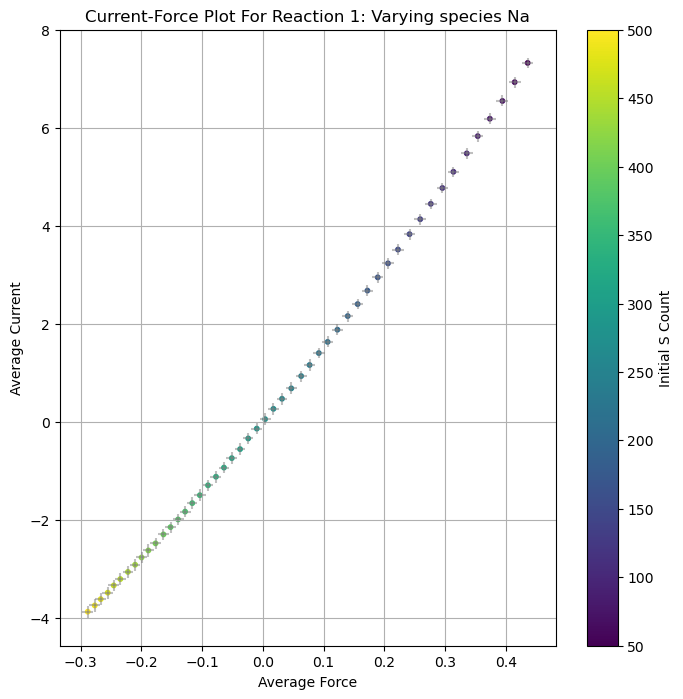

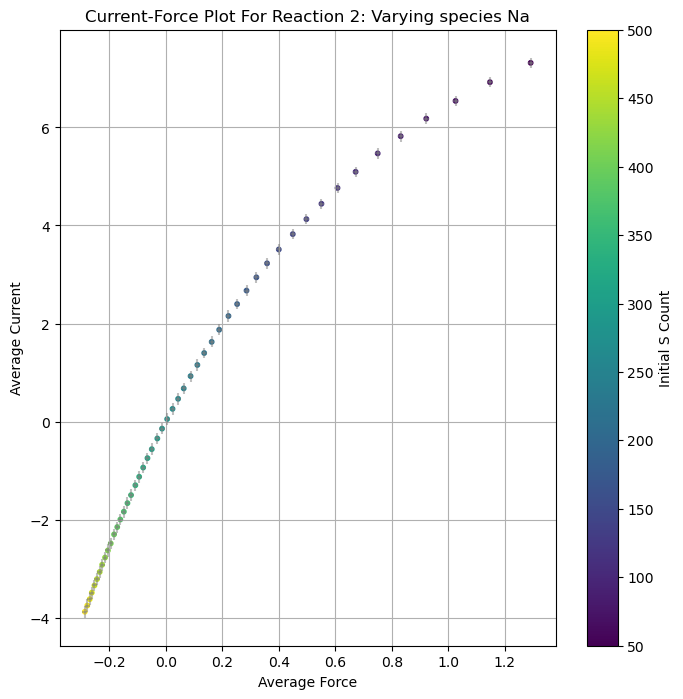

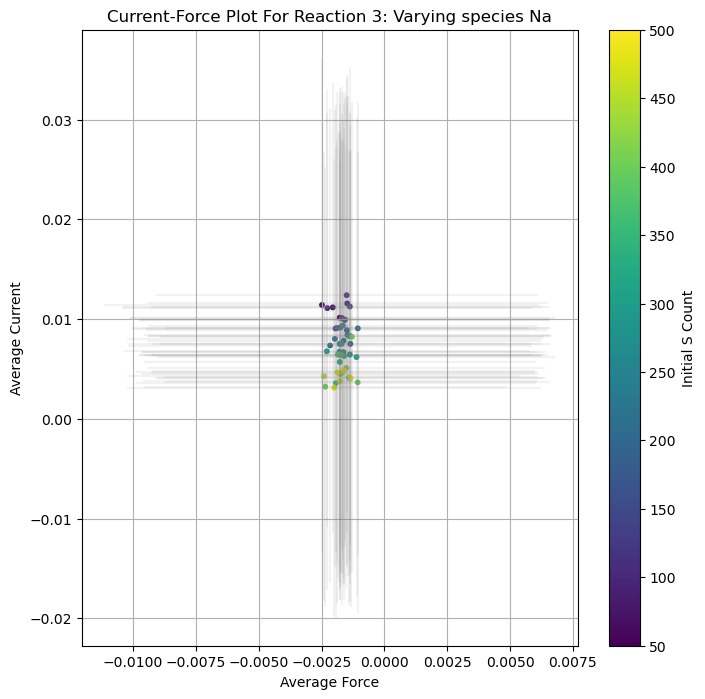

In [ ]:
#
norm = plt.Normalize(vmin=min(initial_S_counts), vmax=max(initial_S_counts))

# Reaction 1
first_reaction_y = [sub[0] for sub in I_axis_means]
first_reaction_x = [sub[0] for sub in F_axis_means]
first_reaction_var_y = [sub[0] for sub in current_variances]
first_reaction_var_x = [sub[0] for sub in force_variances]

plt.title("Current-Force Plot For Reaction 1: Varying species Na")
plt.xlabel("Average Force")
plt.ylabel("Average Current")
plt.grid(True)
plt.errorbar(first_reaction_x, first_reaction_y, yerr=np.sqrt(first_reaction_var_y), xerr=np.sqrt(first_reaction_var_x), fmt='none', ecolor='grey', alpha=0.5)
scatter = plt.scatter(first_reaction_x, first_reaction_y, c=initial_S_counts, cmap='viridis', norm=norm, s=10)
cbar = plt.colorbar(scatter)
cbar.set_label('Initial S Count')
plt.show()

# Reaction 2
second_reaction_y = [sub[1] for sub in I_axis_means]
second_reaction_x = [sub[1] for sub in F_axis_means]
second_reaction_var_y = [sub[1] for sub in current_variances]
second_reaction_var_x = [sub[1] for sub in force_variances]

plt.title("Current-Force Plot For Reaction 2: Varying species Na")
plt.xlabel("Average Force")
plt.ylabel("Average Current")
plt.grid(True)
plt.errorbar(second_reaction_x, second_reaction_y, yerr=np.sqrt(second_reaction_var_y), xerr=np.sqrt(second_reaction_var_x), fmt='none', ecolor='grey', alpha=0.5)
scatter = plt.scatter(second_reaction_x, second_reaction_y, c=initial_S_counts, cmap='viridis', norm=norm, s=10)
cbar = plt.colorbar(scatter)
cbar.set_label('Initial S Count')
plt.show()

# Reaction 3
third_reaction_y = [sub[2] for sub in I_axis_means]
third_reaction_x = [sub[2] for sub in F_axis_means]
third_reaction_var_y = [sub[2] for sub in current_variances]
third_reaction_var_x = [sub[2] for sub in force_variances]

plt.title("Current-Force Plot For Reaction 3: Varying species Na")
plt.xlabel("Average Force")
plt.ylabel("Average Current")
plt.grid(True)
plt.errorbar(third_reaction_x, third_reaction_y, yerr=np.sqrt(third_reaction_var_y), xerr=np.sqrt(third_reaction_var_x), fmt='none', ecolor='grey', alpha=0.1)
scatter = plt.scatter(third_reaction_x, third_reaction_y, c=initial_S_counts, cmap='viridis', norm=norm, s=10)
cbar = plt.colorbar(scatter)
cbar.set_label('Initial S Count')
plt.show()

# Reaction 4
fourth_reaction_y = [sub[3] for sub in I_axis_means]
fourth_reaction_x = [sub[3] for sub in F_axis_means]
fourth_reaction_var_y = [sub[3] for sub in current_variances]
fourth_reaction_var_x = [sub[3] for sub in force_variances]

plt.title("Current-Force Plot For Reaction 4: Varying species Na")
plt.xlabel("Average Force")
plt.ylabel("Average Current")
plt.grid(True)
plt.errorbar(fourth_reaction_x, fourth_reaction_y, yerr=np.sqrt(fourth_reaction_var_y), xerr=np.sqrt(fourth_reaction_var_x), fmt='none', ecolor='grey', alpha=0.5)
scatter = plt.scatter(fourth_reaction_x, fourth_reaction_y, c=initial_S_counts, cmap='viridis', norm=norm, s=10)
cbar = plt.colorbar(scatter)
cbar.set_label('Initial Na Count')
plt.show()

# Reaction 5
fifth_reaction_y = [sub[4] for sub in I_axis_means]
fifth_reaction_x = [sub[4] for sub in F_axis_means]
fifth_reaction_var_y = [sub[4] for sub in current_variances]
fifth_reaction_var_x = [sub[4] for sub in force_variances]

plt.title("Current-Force Plot For Reaction 5: Varying species Na")
plt.xlabel("Average Force")
plt.ylabel("Average Current")
plt.grid(True)
plt.errorbar(fifth_reaction_x, fifth_reaction_y, yerr=np.sqrt(fifth_reaction_var_y), xerr=np.sqrt(fifth_reaction_var_x), fmt='none', ecolor='grey', alpha=0.5)
scatter = plt.scatter(fifth_reaction_x, fifth_reaction_y, c=initial_S_counts, cmap='viridis', norm=norm, s=10)
cbar = plt.colorbar(scatter)
cbar.set_label('Initial Na Count')
plt.show()

## Calculate Gs and compare for different S values (affinities)

### Module 1

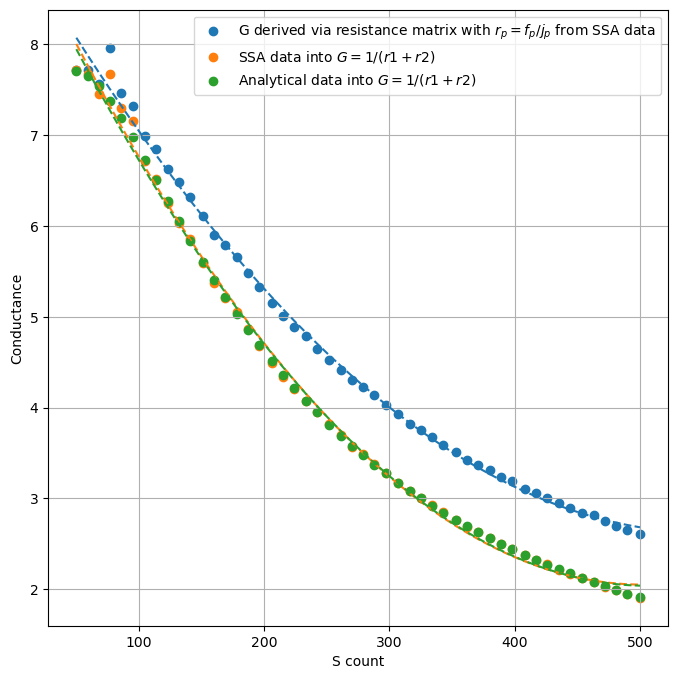

In [231]:
SSA_G_matrices = []
Paper_G_matrices = []
analytical_G = []
M = ModuleProperties(SM, 3, species_names)

for n in range(len(initial_S_counts)):

    r1 = F_axis_means[n][0]/I_axis_means[n][0]
    r2 = F_axis_means[n][1]/I_axis_means[n][1]
    r3 = F_axis_means[n][2]/I_axis_means[n][2]

    resistance_matrix = Matrix([[r1,0,0],[0,r2,0],[0,0,r3]]) # diagonal matrix

    g = M.external_stoich_matrix * M.calculate_reaction_cycle_matrix() * M.calculate_reaction_cycle_matrix().pinv() * resistance_matrix.inv() *  \
        (M.calculate_reaction_cycle_matrix() * M.calculate_reaction_cycle_matrix().pinv()).T * M.external_stoich_matrix.T
    
    G_SSA = float(np.array((M.calculate_selection_matrix().pinv() * g * M.calculate_selection_matrix().T.pinv())))

    #pprint(G)
    SSA_G_matrices.append(G_SSA)

    Paper_G_matrices.append(float(1/(r1+r2)))

    analytical_G.append((analytical_force1[n]/analytical_current1[n] + analytical_force2[n]/analytical_current2[n])**-1)



    
# print(f'r1 + r2 = {1/(F_axis_means[0][0]/I_axis_means[0][0] + F_axis_means[0][1]/I_axis_means[0][1])}' )

plt.scatter(initial_S_counts, SSA_G_matrices, label = 'G derived via resistance matrix with $r_p = f_p / j_p$ from SSA data')
plt.scatter(initial_S_counts, Paper_G_matrices, label = 'SSA data into $G = 1/(r1 + r2)$')
plt.scatter(initial_S_counts, analytical_G, label = 'Analytical data into $G = 1/(r1 + r2)$')

x_sorted = np.sort(initial_S_counts)

# Fit and plot for SSA_G_matrices
coeffs1 = np.polyfit((initial_S_counts), (SSA_G_matrices), 2)
y_fit1 = np.polyval(coeffs1, x_sorted)
plt.plot(x_sorted, y_fit1, linestyle='--', color=plt.gca().collections[0].get_facecolor()[0])

# Fit and plot for Paper_G_matrices
coeffs2 = np.polyfit(initial_S_counts, Paper_G_matrices, 2)
y_fit2 = np.polyval(coeffs2, x_sorted)
plt.plot(x_sorted, y_fit2, linestyle='--', color=plt.gca().collections[1].get_facecolor()[0])

# Fit and plot for analytical_G
coeffs3 = np.polyfit(initial_S_counts, analytical_G, 2)
y_fit3 = np.polyval(coeffs3, x_sorted)
plt.plot(x_sorted, y_fit3, linestyle='--', color=plt.gca().collections[2].get_facecolor()[0])

plt.xlabel("S count")
plt.ylabel("Conductance")
plt.legend()
plt.grid(True)
plt.show()



### Module 2

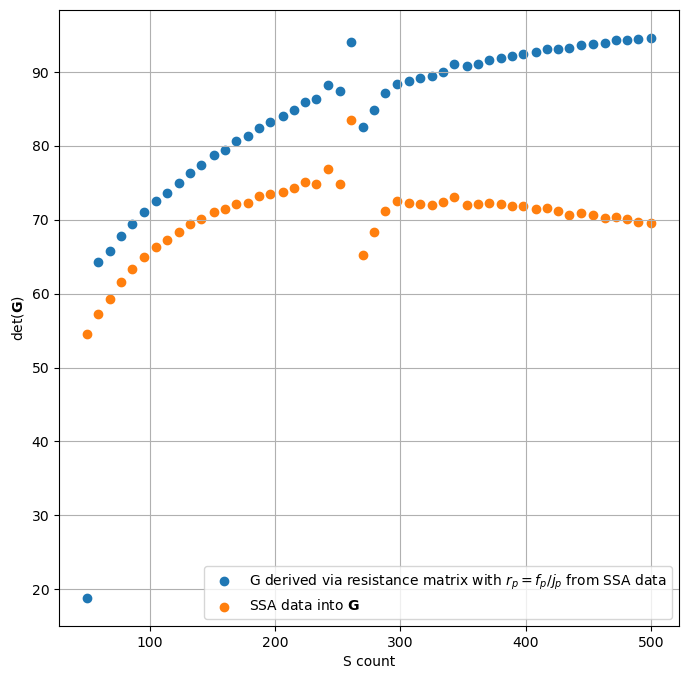

In [312]:
M2 = module_for_simulating2
SSA_G_matrices = []
Paper_G_matrices = []
for n in range(len(initial_S_counts)):

    r1 = F_axis_means[n][0]/I_axis_means[n][0]
    r2 = F_axis_means[n][1]/I_axis_means[n][1]
    r3 = F_axis_means[n][2]/I_axis_means[n][2]
    r4 = F_axis_means[n][3]/I_axis_means[n][3]
    r5 = F_axis_means[n][4]/I_axis_means[n][4]

    resistance_matrix = Matrix([[r1,0,0,0,0],[0,r2,0,0,0],[0,0,r3,0,0],[0,0,0,r4,0], [0,0,0,0,r5]]) # diagonal matrix

    g = M2.external_stoich_matrix * M2.calculate_reaction_cycle_matrix() * M2.calculate_reaction_cycle_matrix().pinv() * resistance_matrix.inv() *  \
        (M2.calculate_reaction_cycle_matrix() * M2.calculate_reaction_cycle_matrix().pinv()).T * M2.external_stoich_matrix.T
    
    G_SSA = np.array(((M.calculate_selection_matrix().pinv() * g * M.calculate_selection_matrix().T.pinv())))

    #pprint(G)
    SSA_G_matrices.append(G_SSA)

    R = np.array((Matrix([[r2 + r4 + r5, -r2],[-r2, r1 + r2 + r3]])))
    
    R_flt = R.astype(np.float64)

    Paper_G_matrices.append((1/np.linalg.det(R_flt)) * np.array((Matrix([[r1 + r2 + r3, r2],[r2,r2 + r4 + r5 ]]))))
    


dets_paper = []
dets_SSA = []
for matrix1 in Paper_G_matrices:
    m1 = matrix1.astype(np.float64)
    dets_paper.append((np.linalg.det(m1)))


for matrix in SSA_G_matrices:
    m2 = matrix.astype(np.float64)
    dets_SSA.append((np.linalg.det(m2)))
    # pprint(matrix)

plt.scatter(initial_S_counts, dets_SSA, label = 'G derived via resistance matrix with $r_p = f_p / j_p$ from SSA data')
plt.scatter(initial_S_counts, dets_paper, label = 'SSA data into $\mathbf{G} $')
plt.xlabel("S count")
plt.ylabel("det($\mathbf{G}$)")
plt.legend()
plt.grid(True)


plt.show()

In [305]:


for n in range(0,5):
    print(F_axis_means[n][0]/I_axis_means[n][0],
        F_axis_means[n][1]/I_axis_means[n][1],
        F_axis_means[n][2]/I_axis_means[n][2],
        F_axis_means[n][3]/I_axis_means[n][3],
        F_axis_means[n][4]/I_axis_means[n][4])

0.03321214462100777 0.050102280493806745 0.02462509016747263 0.35277960785716644 -0.5552118156971093
0.0336915461205308 0.050755425505412115 0.02467851849380511 0.07211452599405119 0.06109357966886258
0.0341219246280592 0.05125003677344566 0.024634621815122902 0.06533349093256456 0.06045524516525098
0.03457279948410187 0.051831744663370406 0.024692315287658258 0.05971463064429887 0.05856361317308755
0.035075231215604796 0.05229604908626348 0.024647463780517142 0.05578621891718137 0.05713552021802711


## Plotting current and force gaussian distributions

In [26]:
all_currents_r1 = []
all_currents_r2 = []
all_currents_r3 = []
# all_currents_r4 = []
# all_currents_r5 = []

for current in currents: # picks out the set of currents for each run, stores in 'current'

    all_currents_r1.append(current[0]) # add the 1st element of the sublist to r1,r2,r3 
    all_currents_r2.append(current[1])
    all_currents_r3.append(current[2])
    # all_currents_r4.append(current[3])
    # all_currents_r5.append(current[4])

J1 = np.array(all_currents_r1)  # length 2000
J2 = np.array(all_currents_r2)
J3 = np.array(all_currents_r3)
# J4 = np.array(all_currents_r4)
# J5 = np.array(all_currents_r5)

# data = np.column_stack((J1, J2, J3))

# np.cov(data, rowvar=False)




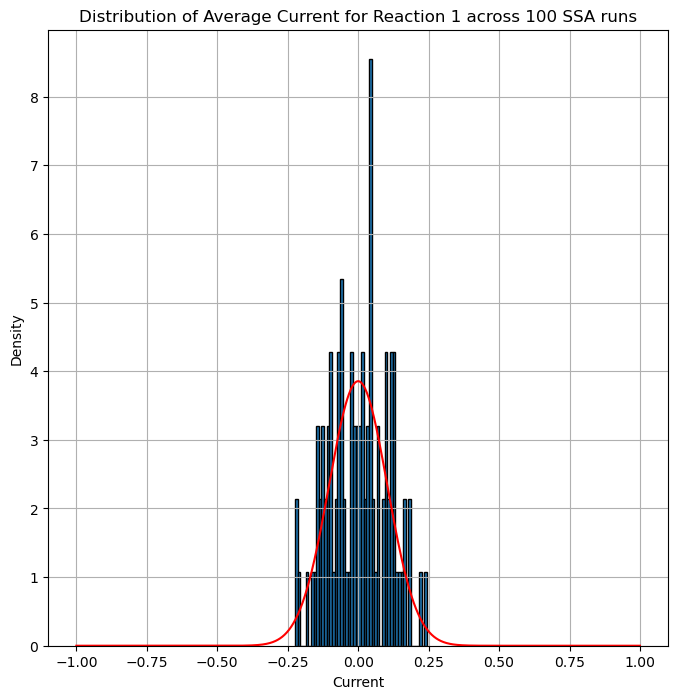

In [27]:
centred_on_0 = J1 - np.mean(J1)
plt.hist(centred_on_0,bins=50,edgecolor='black', density=True)

mean = np.mean(centred_on_0)
std_dev = np.std(centred_on_0)
x = np.linspace(-1, 1 , 1000)
y = (1 / (np.sqrt(2 * np.pi) * std_dev)) * np.exp(-((x - mean)**2) / (2 * std_dev**2))
plt.plot(x, y, color='red')
plt.title(f'Distribution of Average Current for Reaction 1 across {total_iterations} SSA runs')
plt.xlabel('Current')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [28]:
# Look at the different currents for each reaction plotted over each other, look at gaussian dists since we know they fit well

#centred_on_0 = J1 - np.mean(J1)
#plt.hist(J1,bins=50,edgecolor='black', density=True)

J1_centred = J1 #- np.mean(J1)
J2_centred = J2 #- np.mean(J2)
J3_centred = J3 #- np.mean(J3)
J4_centred = J4 #- np.mean(J3)
J5_centred = J5 #- np.mean(J3)

mean1 = np.mean(J1_centred)
std_dev1 = np.std(J1_centred)

mean2 = np.mean(J2_centred)
std_dev2 = np.std(J2_centred)

mean3 = np.mean(J3_centred)
std_dev3 = np.std(J3_centred)

mean4 = np.mean(J4_centred)
std_dev4 = np.std(J4_centred)

mean5 = np.mean(J5_centred)
std_dev5 = np.std(J5_centred)


x5 = np.linspace(190 ,197, 1000)
x4 = np.linspace(190 ,197, 1000)
x3 = np.linspace(160, 165, 1000)
x2 = np.linspace(-33,-26, 1000)
x1 = np.linspace(160, 165, 1000)

y1 = (1 / (np.sqrt(2 * np.pi) * std_dev1)) * np.exp(-((x1- mean1)**2) / (2 * std_dev1**2))
y2 = (1 / (np.sqrt(2 * np.pi) * std_dev2)) * np.exp(-((x2- mean2)**2) / (2 * std_dev2**2))
y3 = (1 / (np.sqrt(2 * np.pi) * std_dev3)) * np.exp(-((x3- mean3)**2) / (2 * std_dev3**2))
y4 = (1 / (np.sqrt(2 * np.pi) * std_dev4)) * np.exp(-((x4- mean4)**2) / (2 * std_dev4**2))
y5 = (1 / (np.sqrt(2 * np.pi) * std_dev5)) * np.exp(-((x5- mean5)**2) / (2 * std_dev5**2))

plt.plot(x1, y1, color='red', label='Reaction 1')
plt.plot(x2, y2, color='blue', label='Reaction 2')
plt.plot(x3, y3, color='green', label='Reaction 3')
plt.plot(x4, y4, color='purple', label='Reaction 4')
plt.plot(x5, y5, color='orange', label='Reaction 5')

plt.title(f'Distribution of Average Current for Each Reaction across {total_iterations} SSA runs')
plt.xlabel('Current NOT centred on mean')
plt.ylabel('Density')
plt.legend()
#plt.xlim(-0,-0.2)
plt.grid(True)



plt.show()

NameError: name 'J4' is not defined

In [ ]:
all_forces_r1 = []
all_forces_r2 = []
all_forces_r3 = []

for force in forces:

    all_forces_r1.append(force[0])
    all_forces_r2.append(force[1])
    all_forces_r3.append(force[2])

F1 = np.array(all_forces_r1)  # length 50
F2 = np.array(all_forces_r2)
F3 = np.array(all_forces_r3)

dataF = np.column_stack((F1, F2, F3))

np.cov(dataF, rowvar=False)



array([[ 1.74926976e-04, -2.58609746e-08, -1.74894148e-04],
       [-2.58609746e-08,  1.35699798e-08,  8.63520976e-09],
       [-1.74894148e-04,  8.63520976e-09,  1.74883187e-04]])

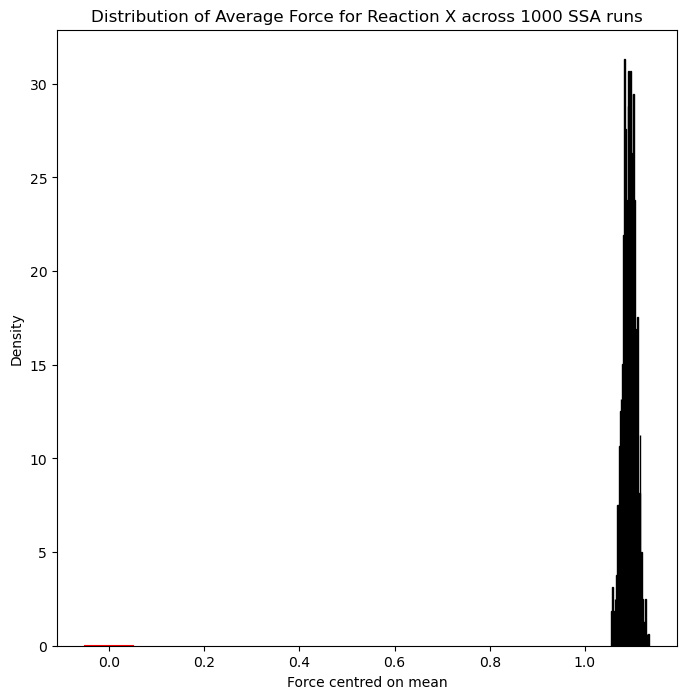

In [ ]:
centred_on_0_F = F3 #- np.mean(F3)
plt.hist(centred_on_0_F,bins=50,edgecolor='black', density=True)

mean_F = np.mean(centred_on_0_F)
std_dev_F = np.std(centred_on_0_F)
x_F = np.linspace(-0.05, 0.05, 1000)
y_F = (1 / (np.sqrt(2 * np.pi) * std_dev_F)) * np.exp(-((x_F - mean_F)**2) / (2 * std_dev_F**2))
plt.plot(x_F, y_F, color='red')
plt.title(f'Distribution of Average Force for Reaction X across {total_iterations} SSA runs')
plt.xlabel('Force centred on mean')
plt.ylabel('Density')

plt.show()

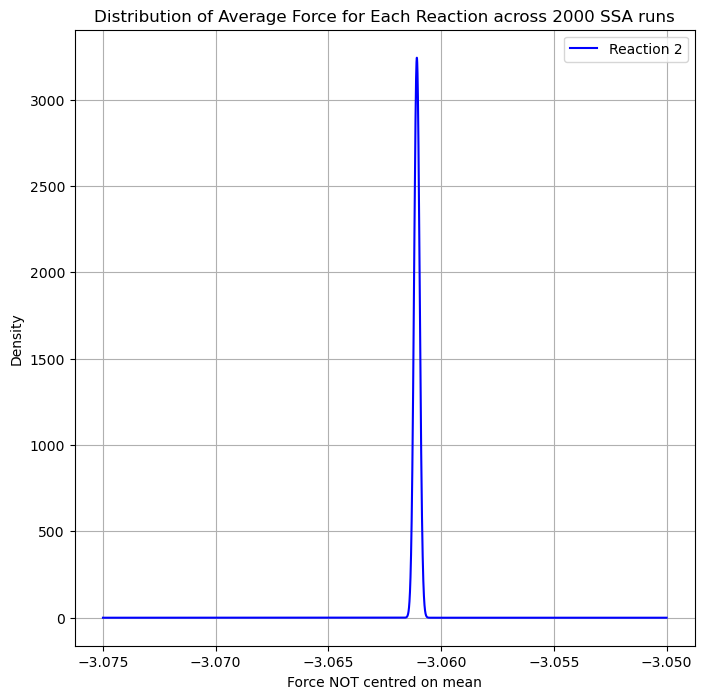

[-3.06174572 -3.06111579 -3.06110891 ... -3.06102866 -3.06108297
 -3.06107749]


In [ ]:
# Look at the different forces for each reaction plotted over each other, look at gaussian dists since we know they fit well

#centred_on_0 = J1 - np.mean(J1)
#plt.hist(J1,bins=50,edgecolor='black', density=True)

F1_centred = F1 #- np.mean(F1) If commented, we are using NON centred values
F2_centred = F2 #- np.mean(F2)
F3_centred = F3 #- np.mean(F3)

mean1F = np.mean(F1_centred)
std_dev1F = np.std(F1_centred)

mean2F = np.mean(F2_centred)
std_dev2F = np.std(F2_centred)

mean3F = np.mean(F3_centred)
std_dev3F = np.std(F3_centred)


xF = np.linspace(-3.075, -3.05, 1000000)
x3F = np.linspace(-1, 1, 1000)

y1F = (1 / (np.sqrt(2 * np.pi) * std_dev1F)) * np.exp(-((xF- mean1F)**2) / (2 * std_dev1F**2))
y2F = (1 / (np.sqrt(2 * np.pi) * std_dev2F)) * np.exp(-((xF- mean2F)**2) / (2 * std_dev2F**2))
y3F = (1 / (np.sqrt(2 * np.pi) * std_dev3F)) * np.exp(-((x3F- mean3F)**2) / (2 * std_dev3F**2))

#plt.plot(xF, y1F, color='red', label='Reaction 1')
plt.plot(xF, y2F, color='blue', label='Reaction 2')
#plt.plot(x3F, y3F, color='green', label='Reaction 3')

plt.title(f'Distribution of Average Force for Each Reaction across {total_iterations} SSA runs')
plt.xlabel('Force NOT centred on mean')
plt.ylabel('Density')
plt.legend()
#epsF = 1e-3
#plt.xlim(mean2F -epsF, mean2F + epsF)
plt.grid(True)




plt.show()

print(F2)


In [ ]:
forces

[[2.8110398979132882, -3.06088768167715, 1.074458266281012], [2.79702413382653 ↪

↪ 74, -3.0610750253953483, 1.0887118449329893], [2.7873757038818074, -3.061109 ↪

↪ 9473331604, 1.0984046048693155], [2.760890932562512, -3.0610326377364476, 1. ↪

↪ 1247912392011836], [2.818659864397268, -3.0610601752236177, 1.06705726351866 ↪

↪ 81], [2.7972929165669926, -3.06100671268888, 1.0883563458790924], [2.7939231 ↪

↪ 32863444, -3.061049739339033, 1.0917807477155244], [2.7886431050224263, -3.0 ↪

↪ 60925988266835, 1.096903685648688], [2.7744723945716636, -3.0609138908310056 ↪

↪ , 1.1110590395854076], [2.783169795088256, -3.0611007543645585, 1.1025988440 ↪

↪ 8648], [2.795843602209847, -3.061125086911507, 1.089955924758321], [2.789782 ↪

↪ 7228524736, -3.0611182963750916, 1.0960081841925025], [2.8080256063536195, - ↪

↪ 3.0610645287373877, 1.0776970479231083], [2.7726871920746823, -3.06103272276 ↪

↪ 27936, 1.1129950876216343], [2.802727123198981, -3.0612127809766436, 1.08318 ↪

↪ 37228258059], 